# Vorlesung: Clustering

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE  

import hdbscan

In [58]:
from ipywidgets import *
from io import BytesIO
from skimage import io
from medDiaJson import getFileBinary

In [59]:
%matplotlib inline

# Clustering mittelalterlicher Diagramme

Die Datenbank mittelalterlicher Diagramme wird von Github eingelesen und in einen Dataframe geschrieben.

In [60]:
url = 'https://raw.githubusercontent.com/grasshoff/ComputationalHistoryScience/master/diaattr.json'
diagrams = pd.read_json(url)
diagrams.head()

,altID,author,biblio,diaAttr,diaID,diaTyp,diaURL,foliopage,manID,manURL,textID,textURL,year
0,Plin4,Plinius,"Vaticano BAV, Ross. 247","[{'M2.7': 1, 'M2.22': 0, 'M2.15': 0, 'M2.8': 1...",MAPD0668,2,Dl_1&pn=396&dw=1858&dh=901&ww=0.8926&wh=0.6552...,200v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
1,Plin41,Plinius,"Vaticano BAV, Ross. 247","[{'M3.19': 0, 'M3.24': 0, 'M3.7': 1, 'M3.14': ...",MAPD0670,3,Dl_1&pn=395&dw=1858&dh=901&ww=0.9617&wh=0.7723...,200r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
2,Plin67,Plinius,"Vaticano BAV, Ross. 247","[{'M4.3': '?', 'M4.1': 0, 'M4.7': 0, 'M4.2': 0...",MAPD0698,4,Dl_1&pn=414&dw=1858&dh=901&ww=0.9085&wh=0.6452...,209v,DL(1),Dl_1&pn=1,DL(1)_A,,IX
3,Plin82,Plinius,"Vaticano BAV, Ross. 247","[{'M6.2': 0, 'M6.20': 0, 'M6.13': 1, 'M6.17': ...",MAPD0714,6,Dl_1&pn=393&dw=1858&dh=901&ww=0.8255&wh=0.62&w...,199r,DL(1),Dl_1&pn=1,DL(1)_A,,IX
4,Plin6,Plinius,"Paris BN, 11130","[{'M2.7': 0, 'M2.22': 0, 'M2.15': 0, 'M2.8': 1...",MAPD0690,2,Jk_2&pn=1&dw=1858&dh=901&ww=1&wh=1&wx=0&wy=0,74v,JK(2),Jk_2&pn=1,JK(2)_A,,XII


Die Diagramme sind nach Merkmalen in Diagramm-Typen vor-kategorisiert. Es gibt 27 verschiedene Diagramm-Typen, mit jeweils etwa 30 Merkmalen. Jedes Diagramm kann die spezifischen Merkmale haben (=1) oder nicht haben (=0). Merkmale anderer Diagramm-Typen werden auf Null gesetzt, nicht vorhandene oder unklare Merkmalsattribute werden mit dem Wert 0.5 beschrieben. 

Um ein Clustering der Diagramme nach Merkmalen durchzuführen, erzeugen wir als erstes einen Dataframe, welcher nur die ID des Diagramms und seine Merkmale enthält. 

In [61]:
merkmaleV=diagrams[["author","diaID","diaAttr"]].reset_index(drop=True)
merkmaleV.head()

,author,diaID,diaAttr
0,Plinius,MAPD0668,"[{'M2.7': 1, 'M2.22': 0, 'M2.15': 0, 'M2.8': 1..."
1,Plinius,MAPD0670,"[{'M3.19': 0, 'M3.24': 0, 'M3.7': 1, 'M3.14': ..."
2,Plinius,MAPD0698,"[{'M4.3': '?', 'M4.1': 0, 'M4.7': 0, 'M4.2': 0..."
3,Plinius,MAPD0714,"[{'M6.2': 0, 'M6.20': 0, 'M6.13': 1, 'M6.17': ..."
4,Plinius,MAPD0690,"[{'M2.7': 0, 'M2.22': 0, 'M2.15': 0, 'M2.8': 1..."


Der Übersichtlichkeit halber, werden die Diagramme eines einzelnen Authors ausgewählt. 

In [62]:
set(merkmaleV['author'].values)

{'Calcidius', 'Capella', 'Macrobius', 'Plinius'}

In [63]:
merkmaleCapella = merkmaleV[merkmaleV['author']=='Capella']
merkmaleCapella.head()

,author,diaID,diaAttr
314,Capella,MAPD0345,"[{'M22.1': 0, 'M22.3': 0, 'M22.5': 1, 'M22.4':..."
411,Capella,MAPD0347,"[{'M20.1': 0, 'M20.5': 0, 'M20.4': 0, 'M20.2':..."
466,Capella,MAPD0386,"[{'M21.7': 0, 'M21.3': 1, 'M21.6': 0, 'M21.5':..."
467,Capella,MAPD0397,"[{'M22.1': 1, 'M22.3': 1, 'M22.5': 0, 'M22.4':..."
519,Capella,MAPD0292,"[{'M19.5': 0, 'M19.1': 1, 'M19.4': 0, 'M19.2':..."


Da der Attribute-Wert als Liste gepseichert ist, erzeugen wir für jedes Diagram einen neuen Dataframe und schreiben diesen in eine Liste.

In [64]:
frames=[]
for i in range(len(merkmaleCapella)):
    j=pd.DataFrame(merkmaleCapella["diaAttr"].iloc[i])
    j['diaID'] = merkmaleCapella['diaID'].iloc[i]
    frames.append(j)   

Aus dieser Liste erzeugen wir mit pd.concat einen neuen Dataframe, der sämtliche Informationen enthält. Nicht vorhande Werte werden durch Null dargestellt. Sonst würde Pandas NaN (Not a Number) Werte setzen, mit denen die Clustering-Algorithmen nicht umgehen können.

In [65]:
rplNaN = 0
    
MerkmaleDia=pd.concat(frames,ignore_index=True).fillna(rplNaN)

Die Daten müssten weiter bereinigt werden, wenn es noch andere Werte außer Zahlen gibt. Hiervon sind die Diagramm-IDs ausgenommen (beginnend mit MAPD).

In [66]:
vlList = list(pd.unique(MerkmaleDia.values.ravel()))
[x for x in vlList if 'MAPD' not in str(x)]

[0, 1, '?', 'no attributes']

Mit dieser Liste könne Ersetzungs-Regeln definiert werden. Um die ambivalente Kodierung zu erhalten, wird mit dem Wert 0.5 ersetzt.

In [67]:
rplBy = 0.5

if '?' in vlList:
    MerkmaleDia.replace(['?'],[rplBy],inplace=True)
if 'no attributes' in vlList:
    MerkmaleDia.replace(['no attributes'],[rplBy],inplace=True)
if '' in vlList:
    MerkmaleDia.replace([''],[rplBy],inplace=True)

In [68]:
MerkmaleDia.head()

,M0,M18.1,M18.2,M18.3,M18.4,M18.5,M19.1,M19.2,M19.3,M19.4,...,M31.19,M31.2,M31.3,M31.4,M31.5,M31.6,M31.7,M31.8,M31.9,diaID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAPD0345
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAPD0347
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAPD0386
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAPD0397
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAPD0292


Eine Matrix erhält man durch den df.values Befehl.

In [69]:
X = MerkmaleDia.values

Über die Diagramm-ID kann das Bild des Diagramms aus dem edition-topoi repository geladen werden.

In [70]:
diaIDs = dict(MerkmaleDia['diaID'])

In [71]:
diaIDs[0]

'MAPD0345'

In [72]:
def imgShow(index):
    diaID = int(index)
    file = getFileBinary(diaIDs[diaID])
    if type(file) == str:
        image = np.ones((10,3,3))
        pass
    else:
        image = io.imread(BytesIO(file))

    fig, axs = plt.subplots(1, 1, sharex=False, sharey=False)
    axs.axis('off')
    print(diaIDs[diaID])
    img = axs.imshow(image);
    return img

MAPD0345


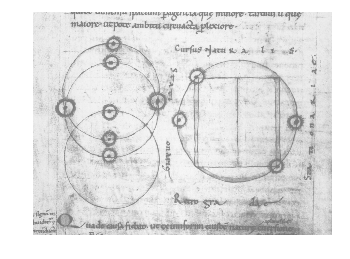

In [73]:
j = widgets.interactive(imgShow, index=list(diaIDs.keys()))
HBox([j])

Die Spalte mit den Diagramm-IDs wird nun erstmal fallen gelassen. Später kann über den Index die zugehörige Diagramm-ID ausgelesen werden.

In [74]:
data = np.delete(X,-1,axis=1)
data

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ..., 
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

## Projektion des Merkmal-Raums auf 2D

Für eine 2D Darstellung muss eine Projektion verwendet werden, da die Daten selbst die Dimensionen 721 (Diagramme) x 585 (Merkmale) haben. 
Hierfür bietet sich TSNE aus dem Paket sklearn an. Die Beschreibung der Funktionsweise findet sich unter http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Diese Projektion ist stochastisch, das heißt bei einem neuen Aufruf kann sich eine andere Verteilung ergeben. Die Projektion dient nur zur Darstellung, zB für verschiedene Cluster-Größen oder Abstandsmaße. 

In [75]:
projection = TSNE().fit_transform(data)

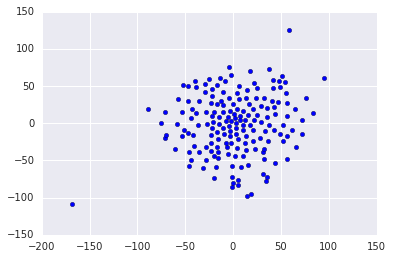

In [76]:
plt.scatter(*projection.T)

## Clustering

Als Clustering-Algorithmus verwenden wir HDBSCAN, eine Weiterentwicklung im Umfeld des Scikit-Learn Pakets https://github.com/scikit-learn-contrib/hdbscan 

Erst wird der Clusterer initialisiert. Ein Aufruf mit `cluster.fit(data)` führt dann das Clustering durch. In der Ausgabe sieht man, welche Parameter als Standard benutzt werden.

In [77]:
clusterer = hdbscan.HDBSCAN(metric='euclidean',min_cluster_size=4, min_samples=2, gen_min_span_tree=True)
clusterer.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=True,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='euclidean', min_cluster_size=4,
    min_samples=2, p=None)

Jedes Diagramm wird einem Cluster zugeordnet, in Abhängigkeit seiner "Entfernung" zu anderen Diagrammen. Als Entfernungsmaße können verschiedene Algorithmen zum Einsatz kommen. Dazu später mehr. 

Die Zuordnung eines Diagrammes zu einem Cluster erhält man über den Befehl `clusterer.labels_`. Diagramme, die einem zu kleinen Cluster zugeordnet werden (kleiner als 4) erhalten das Label -1.

In [78]:
clusterer.labels_[:20]

array([-1, 13, -1,  6, 10, -1, -1, -1,  8, -1,  8,  1, -1, 11,  1, -1,  6,
        1,  8, -1])

Es gibt 16 verschiedene Cluster.

In [79]:
clusterer.labels_.max()

16

Die Nähe zu einem Cluster-Kern wird mit `clusterer.probabilities_` beschrieben.

In [80]:
clusterer.probabilities_[:40]

array([ 0.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.81649658,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ])

## Grundlage des Algorithmus

Die grundlegende Idee des HDBSCAN Clusteres ist, ein gewichtetes Abstandsmaß für die Daten einzuführen, welches erlaubt Daten von Rauschen zu trennen. Anschaulich wird um jeden Datenpunkt ein Kreis gezogen, der `min_sample`=4 Punkte enthält. Der Radius zweier Punkte wird mit ihrem Abstand, berechnet je nach gewünschter Metrik, verglichen und der größte Wert wird als Entfernung der zwei Datenpunkte definiert. 

Ausgehend von diesen Abstandsdaten wird nun ein zufälliger Datenpunkt ausgewählt und eine Verbindung zu dem Datenpunkt mit dem geringsten Abstand gezogen. Dies wird so lange fortgesetzt, bis alle Datenpunkte verknüpft sind. Dieses neue Netzwerk bezeichnet man als Minimal Spanning Tree. 

Schließlich kann für die Erzeugung eines Dendrogramms wieder die Entfernung genutzt werden. Ausgehend von der geringsten Entfernung werden Cluster zusammengefügt, bis nur noch ein Cluster existiert. Diese neuen Cluster erhalten neue Indices, sodass zB für die Diagramme neue Cluster bei 722 starten.

In der Erzeugung des Minimal Spanning Trees gibt es leider einen Fehler in dem Paket, da der Parameter der die Erzeugung steuert nicht richtig übergeben wird.

In [81]:
#clusterer.minimum_spanning_tree_.plot()

In [82]:
clusterer.gen_min_span_tree

True

## Dendrogramm Darstellung

Die Hierachie der Cluster kann mit einem Dendrogramm dargestellt werden. Um die Übersichtlichkeit zu erhöhen, werden nur die 15 letzten Level dargestellt. Die Breite der Linie und ihre Farbe kodieren die Anzahl der Diagramme pro Cluster. 

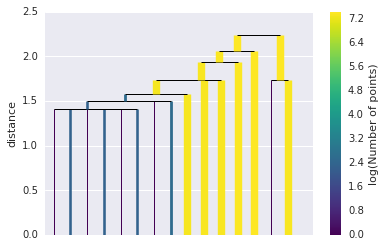

In [83]:
clusterer.single_linkage_tree_.plot(truncate_mode='lastp',p=15,cmap='viridis', colorbar=True)

Eine reduzierte Ansicht erhält man mit dem Condesed Tree. Hier werden nach und nach Verbindungen aus dem Haupt-Cluster entfernt. Knoten-Punkte die unter die minimale Cluster-Größe fallen, werden nicht mehr dargestellt.  

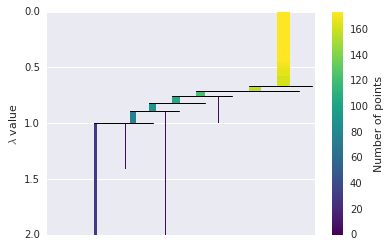

In [84]:
clusterer.condensed_tree_.plot()

Die Information in diesem Dendrogramm kann direkt als Dataframe ausgegeben werden. 

In [85]:
dfClusterCond = clusterer.condensed_tree_.to_pandas()
dfClusterCond.head()

,parent,child,lambda_val,child_size
0,174,133,0.447214,1
1,174,24,0.447214,1
2,174,15,0.447214,1
3,174,52,0.485071,1
4,174,78,0.485071,1


## Einfluss verschiedener Parameter auf Cluster Erzeugung

### Minimale Cluster Größe

Die minimale Cluster Größe hat einen großen Einfluss auf die Cluster-Bildung. Dies kann am besten mit einer Projektion in 2D dargestellt werden. 

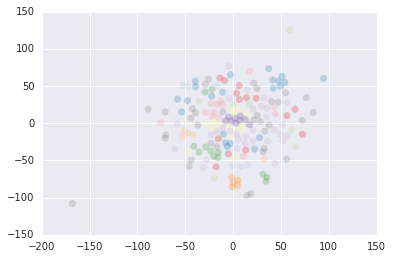

In [86]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=1).fit(data)
color_palette = sns.color_palette('Paired', 48)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

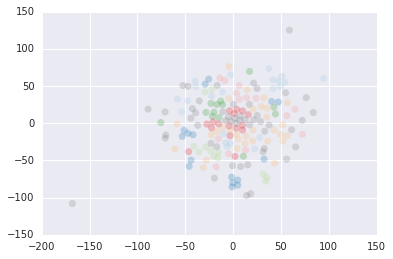

In [87]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10,min_samples=1).fit(data)
color_palette = sns.color_palette('Paired', 48)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

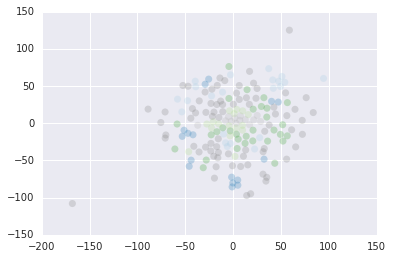

In [88]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15,min_samples=1).fit(data)
color_palette = sns.color_palette('Paired', 48)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

### Metrik

Die Auswahl der Metrik bestimmt, welches Entfernungsmaß für die Attribut-Beschreibung verwendet werden soll. Es gibt drei grundlegend unterschiedliche Gruppen von Maßen, je nachdem welche Werte die Beschreibungs-Vektoren annehmen können:

    reelle Zahlen: zB euclidean, minkowski, chebyshev
    ganze Zahlen: Hamming, Canberra, Braycurtis
    boolsche Werte (True/False): jaccard, dice (Für reelle Zahlen werden Werte ungleich null als True gesetzt.)

Die Liste aller möglichen Metriken erhält man wie unten, die Beschreibung der Mathematik dahinter findet sich im Quelltext https://github.com/scikit-learn-contrib/hdbscan/blob/master/hdbscan/dist_metrics.pyx

In [89]:
hdbscan.dist_metrics.METRIC_MAPPING

{'arccos': hdbscan.dist_metrics.ArccosDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'cosine': hdbscan.dist_metrics.ArccosDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'haversine': hdbscan.dist_metrics.HaversineDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dis

In [90]:
clusterer = hdbscan.HDBSCAN(metric='minkowski',p=3,min_cluster_size=5,min_samples=3)
clusterer1 = hdbscan.HDBSCAN(metric='hamming',min_cluster_size=5,min_samples=3)
clusterer2 = hdbscan.HDBSCAN(metric='braycurtis',min_cluster_size=5,min_samples=3)

In [91]:
clusterer.fit(data)
clusterer1.fit(data)
clusterer2.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='braycurtis', min_cluster_size=5,
    min_samples=3, p=None)

In [92]:
color_palette = sns.color_palette('Paired', 50)

cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

cluster_colors1 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer1.labels_]
cluster_member_colors1 = [sns.desaturate(x, p) for x, p in zip(cluster_colors1, clusterer1.probabilities_)]

cluster_colors2 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer2.labels_]
cluster_member_colors2 = [sns.desaturate(x, p) for x, p in zip(cluster_colors2, clusterer2.probabilities_)]

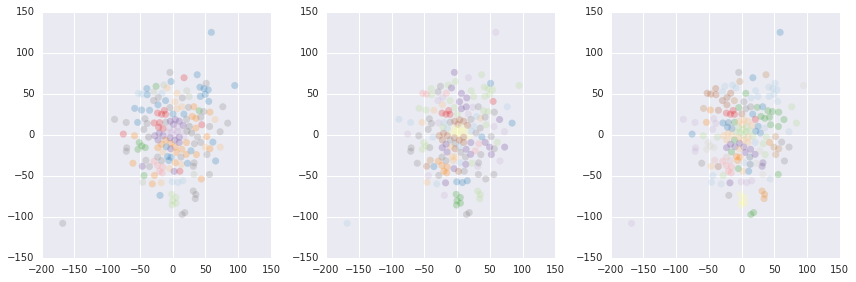

In [93]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
ax2.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors1, alpha=0.25)
ax3.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors2, alpha=0.25)

plt.tight_layout()

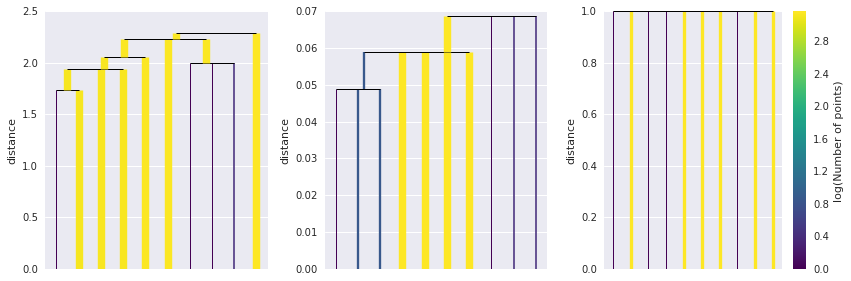

In [94]:
#fig = plt.figure(,sharey=True)
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=False, sharey=False)

clusterer.single_linkage_tree_.plot(truncate_mode='lastp',p=10,cmap='viridis', colorbar=False, axis=ax[0])
clusterer1.single_linkage_tree_.plot(truncate_mode='lastp',p=10,cmap='viridis', colorbar=False, axis=ax[1])
clusterer2.single_linkage_tree_.plot(truncate_mode='lastp',p=10,cmap='viridis', colorbar=True, axis=ax[2])

plt.tight_layout()

### Selbst definierte Metriken

Über die Auswahl von pyfunc soll auch das definieren eigener Metriken möglich sein. Diese könnte spezielles Wissen über die Daten beinhalten. So sollte es zB schwerer sein, ein Merkmal bei dem Kopieren von Diagrammen hinzuzufügen als wegzulassen. Daher sollte die "Entfernung" von 0 zu 1 größer sein als 1 zu 0. Damit wäre die so definierte Entfernung keine eigentliche Metrik mehr, da für diese immer Symmetrie ( d(x,y) = d(y,x) ) gelten muss.

In [95]:
def weightedattributes(u,v):
    dist = np.sqrt((1/(u+1)*(u-v)**2).sum())
    return dist

# Clustering von Texten

In [96]:
textMerkmale=diagrams[["author","diaID","diaAttr","textID"]].reset_index(drop=True)
dfCapella = textMerkmale[textMerkmale['author']=='Capella']
dfCapella.head()

,author,diaID,diaAttr,textID
314,Capella,MAPD0345,"[{'M22.1': 0, 'M22.3': 0, 'M22.5': 1, 'M22.4':...",LK(1)_B
411,Capella,MAPD0347,"[{'M20.1': 0, 'M20.5': 0, 'M20.4': 0, 'M20.2':...",NW(2)_A
466,Capella,MAPD0386,"[{'M21.7': 0, 'M21.3': 1, 'M21.6': 0, 'M21.5':...",AY(3)_A
467,Capella,MAPD0397,"[{'M22.1': 1, 'M22.3': 1, 'M22.5': 0, 'M22.4':...",AY(3)_A
519,Capella,MAPD0292,"[{'M19.5': 0, 'M19.1': 1, 'M19.4': 0, 'M19.2':...",AY(1)_A


In [97]:
dfList = []
for text in dfCapella['textID']:
    dfTemp = dfCapella[dfCapella['textID']==text]
    subList = []
    for i in range(len(dfTemp)):
        j = pd.DataFrame(dfTemp['diaAttr'].iloc[i])
        subList.append(j)
    dfTemp2 = pd.concat(subList,axis=1).fillna(0)
    dfList.append(dfTemp2)  

In [98]:
len(dfList)

174

In [99]:
dfTexte = pd.concat(dfList[:100]).fillna(0)
dfTexte.head()

,M0,M18.1,M18.2,M18.3,M18.4,M18.5,M19.1,M19.2,M19.3,M19.4,...,M31.18,M31.19,M31.2,M31.3,M31.4,M31.5,M31.6,M31.7,M31.8,M31.9
0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0,0.0,0.0,0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0


In [100]:
dfTexte = dfTexte.drop('M0',1)

In [101]:
dfTexte.head()

,M18.1,M18.2,M18.3,M18.4,M18.5,M19.1,M19.2,M19.3,M19.4,M19.5,...,M31.18,M31.19,M31.2,M31.3,M31.4,M31.5,M31.6,M31.7,M31.8,M31.9
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0


In [102]:
vlList = list(pd.unique(dfTexte.values.ravel()))
[x for x in vlList if 'MAPD' not in str(x)]

[0.0, 1, '?']

In [103]:
rplBy = 0.0

if '?' in vlList:
    dfTexte.replace(['?'],[rplBy],inplace=True)
if 'no attributes' in vlList:
    dfTexte.replace(['no attributes'],[rplBy],inplace=True)
if '' in vlList:
    dfTexte.replace([''],[rplBy],inplace=True)

In [104]:
dataTexte = dfTexte.values
dataTexte

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [105]:
projectionTexte = TSNE().fit_transform(dataTexte)

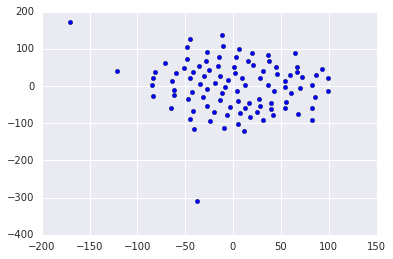

In [106]:
plt.scatter(*projectionTexte.T)

In [107]:
clustererTexte = hdbscan.HDBSCAN(metric='minkowski',p=3,min_cluster_size=5,min_samples=3)
clustererTexte1 = hdbscan.HDBSCAN(metric='hamming',min_cluster_size=5,min_samples=3)
clustererTexte2 = hdbscan.HDBSCAN(metric='braycurtis',min_cluster_size=5,min_samples=3)

In [108]:
clustererTexte.fit(dataTexte)
clustererTexte1.fit(dataTexte)
clustererTexte2.fit(dataTexte)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, match_reference_implementation=False,
    memory=Memory(cachedir=None), metric='braycurtis', min_cluster_size=5,
    min_samples=3, p=None)

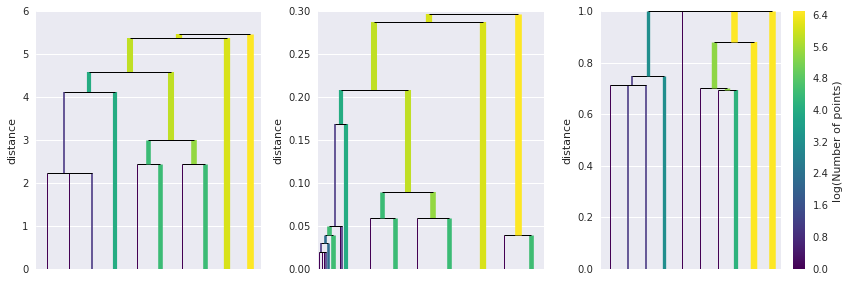

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=False, sharey=False)

clustererTexte.single_linkage_tree_.plot(truncate_mode='lastp',p=10,cmap='viridis', colorbar=False, axis=ax[0])
clustererTexte1.single_linkage_tree_.plot(p=10,cmap='viridis', colorbar=False, axis=ax[1])
clustererTexte2.single_linkage_tree_.plot(truncate_mode='lastp',p=10,cmap='viridis', colorbar=True, axis=ax[2])

plt.tight_layout()

In [110]:
color_palette = sns.color_palette('Paired', 50)

cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clustererTexte.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clustererTexte.probabilities_)]

cluster_colors1 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clustererTexte1.labels_]
cluster_member_colors1 = [sns.desaturate(x, p) for x, p in zip(cluster_colors1, clustererTexte1.probabilities_)]

cluster_colors2 = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clustererTexte2.labels_]
cluster_member_colors2 = [sns.desaturate(x, p) for x, p in zip(cluster_colors2, clustererTexte2.probabilities_)]

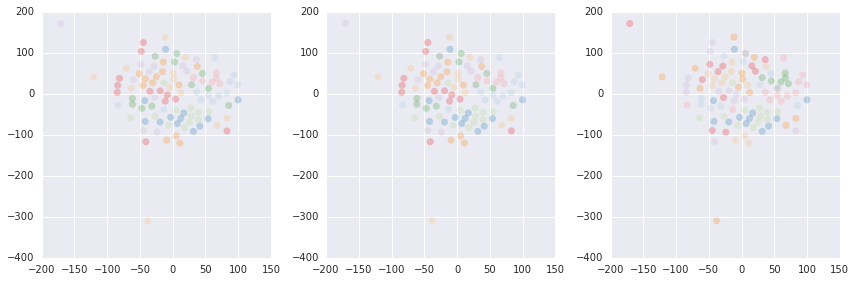

In [111]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(*projectionTexte.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
ax2.scatter(*projectionTexte.T, s=50, linewidth=0, c=cluster_member_colors1, alpha=0.25)
ax3.scatter(*projectionTexte.T, s=50, linewidth=0, c=cluster_member_colors2, alpha=0.25)

plt.tight_layout()